# Save events of AEs

- Load the waveform from the pick and location output and save into pickle.

- upddated: use relocated file

- 2023.10.22 update for fb03-087
- 2024.10.31 update for the merged catalog

In [1]:
import os
import obspy
from obspy import read, Stream, Trace
from scipy import signal
import matplotlib.pyplot as plt
import glob
from glob import glob
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from tqdm import tqdm
import pickle
import warnings
from obspy.core.utcdatetime import UTCDateTime    
from matplotlib import cm
import matplotlib as mpl
import itertools
import mpl_interactions.ipyplot as iplt
import scipy.io as sio

%matplotlib ipympl

%load_ext autoreload
%autoreload 2

from IPython import display
import time

from AE_compute_location_func import store_trace

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 12
os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion

UTCDateTime.DEFAULT_PRECISION = 8 # increase the time precision


In [2]:
figdir = "../figure/AElocation"
if not os.path.exists(figdir):
    os.makedirs(figdir)

In [3]:
# Directory for picked waveforms
datadir = "../data/AElocation"

# Data outputdir
outdir = "../data/03_AEobs_waveform"

# channel table
channel_finame = '../../Others/AEchanneltable/AEsensorlocation_onFB03_table.csv'

if not os.path.exists(outdir):
    os.makedirs(outdir)
    
csvdir =  "../data/datacsv"
if not os.path.exists(csvdir):
    os.makedirs(csvdir)

In [4]:
# Paramters
fs      = 10e6 #[Hz] Sampling frequency of data
Nsensor = 32 # Number of sensors
st_stats = UTCDateTime(2023, 5, 29) # starttime for the stats of trace: used to synchronize the data. Should be same with picking script.
expr_id= 87 # casename of experiment

ev_twinlen = 0.4e-3 #[s] window length of event
ev_pretrigger = 0.1e-3 #[s] duration of pretrigger

ev_twinlen_k = np.round(ev_twinlen*fs)

## Read channel array

In [5]:
df_array = pd.read_csv(channel_finame)

channel_loc={}

for i in range(len(df_array)):
    stnm = df_array.iloc[i].Instrument_Label
    xtemp = df_array.iloc[i].North.astype('float')
    ytemp = df_array.iloc[i].East.astype('float')
    ztemp = df_array.iloc[i].Down.astype('float')
    channel_loc[stnm] = [xtemp, ytemp, ztemp]
    
Nsensor = len(channel_loc)
# channel_loc

## Read catalog

In [6]:
# Read picked catalog
# Read the csv pick datasheet
fi_catalog="../../Experiments/DetectEvent/data/p06_visual_pick_gougeevents_merged.csv"
columns = ["expr_id", "event_id", "event_loc", "picktime", "event_type", "rupturetype", "gougeevent_id", "doublecheck", "old_gougeevent_id"]
df_catalog = pd.read_csv(fi_catalog, skiprows=5, names=columns)
df_expr = df_catalog[(df_catalog["expr_id"]==f"fb03-{expr_id:03d}")]
df_expr.head()

,expr_id,event_id,event_loc,picktime,event_type,rupturetype,gougeevent_id,doublecheck,old_gougeevent_id
0,fb03-087,2,2.75,41.02500,LFE,2,0,1,0
1,fb03-087,3,1.25,42.46400,LFE,1,1,1,1
2,fb03-087,3,1.25,42.46450,Ordinary,1,2,1,2
3,fb03-087,3,3.25,42.46790,Ordinary,1,3,1,212
4,fb03-087,3,1.75,42.47475,Ordinary,1,4,1,3


# Read location and pick time

skip the event if the time window is too close (overlapped) because they are identical events.

In [7]:
df_event = pd.DataFrame(columns=["gougeevent_id", "stickslip_id", "exprID", "origin_time", "X", "Y", "V", "Vs", "dx_best", "dy_best"])

pickdir_list = sorted(glob(os.path.join(datadir, "relocation/*")))
origintime_prev = 0

for pickdir in pickdir_list:
    
    foreshock_id = int(os.path.basename(pickdir))
    stickslipevent_id = df_expr[df_expr["gougeevent_id"]==foreshock_id]["event_id"].values[0] # event_id of stick-slip

    
    finame_loc = os.path.join(pickdir, "eventloc__fb03-{:03d}__{:04d}.pickle".format(expr_id, foreshock_id))
    if os.path.exists(finame_loc):
        print(f"start processing event {foreshock_id:04d}")
        with open(finame_loc, "rb") as fi:
            tpick_reloc = pickle.load(fi)
    else:
        continue #skipping this event because no pick file found.

#     finame_pick = os.path.join(pickdir, "tpick__fb03-{:03d}__{:04d}.pickle".format(expr_id, foreshock_id))
#     if os.path.exists(finame_pick):
#         with open(finame_pick, "rb") as fi:
#             tpick = pickle.load(fi)

    
    # skip if origin time is too close to the previous event
    if np.abs(origintime_prev - tpick_reloc["origin_abs_t"]) < 0.1e-3: # less than 0.1 millisecond
        origintime_prev = tpick_reloc["origin_abs_t"]
        print("skip because the origintime is too close")
        continue
        
    # append to dataframe
    df_event = pd.concat([df_event, pd.DataFrame(data={
                                             "gougeevent_id":[foreshock_id],
                                             "stickslip_id":[stickslipevent_id],
                                             "exprID":[f"fb03-{expr_id:03d}"],
                                             "origin_time":[tpick_reloc["origin_abs_t"][0][0]],
                                             "X": [tpick_reloc["X"]],
                                             "Y": [tpick_reloc["Y"]],
                                             "V": [tpick_reloc["V"]],
                                             "Vs": [tpick_reloc["Vs"]],
                                             "dx_best": [tpick_reloc["dx_best"]],
                                             "dy_best": [tpick_reloc["dy_best"]],
                                            })])

    # compute tpick from origin time
    tpick_rel = tpick_reloc["tpick_rel"] # updated relative tpick during relocation process
    
#     for key in tpick:
#         tpick_rel[key] = ( tpick_loc["init_abs_t"] + tpick[key]*1e-3 ) - tpick_loc["origin_abs_t"]# tpick is in ms.

    # read waveform
    
    # read waveform
    data_rootdir = f"/Volumes/4mGouge_WorkHDD/FB03data/4mBIAX_paper_tmp/p03_eventdata_FB03_{expr_id:03d}/"
    fname = f"eventdata_FB03_087_event{stickslipevent_id:02d}"

    D = sio.loadmat(data_rootdir+fname)

    # read data
    print(tpick_reloc["origin_abs_t"])
    read_starttime = tpick_reloc["origin_abs_t"] - D["Tstart"] - ev_pretrigger
    init_k = int(read_starttime*fs) # trim start time from picktime - pretrig
    datmat = D['AEdatmat'][init_k:int(init_k+ev_twinlen_k), :]

#     read_init_t = tpick_reloc["origin_abs_t"] - ev_pretrigger #[s]
#     datmat,tmat,Ch_info=SBENCHreader(read_init_t, ev_pretrigger+ev_twinlen, pname, runID, pretrigger=False)

    st_obs = store_trace(datmat, fs, st_stats, tpick_reloc["origin_abs_t"] - ev_pretrigger)
    st_obs.channel_loc = channel_loc

    # store metadata
    st_obs.pretrigger = ev_pretrigger
    st_obs.eventloc = tpick_reloc
    st_obs.tpick_rel = tpick_rel
    st_obs.st_stats = st_stats
    st_obs.runID = f"fb03-{expr_id:03d}"

    foname = os.path.join(outdir, "obs_waveform_event__fb03-{:03d}__{:04d}.pickle".format(expr_id, foreshock_id))
    st_obs.write(foname, format="PICKLE")
    # update origintime
    origintime_prev = tpick_reloc["origin_abs_t"]

start processing event 0004


100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 12204.94it/s]

[[42.47477226]]
start processing event 0009



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 23444.14it/s]

[[47.66269341]]
start processing event 0018



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 25276.41it/s]

[[56.72704421]]
start processing event 0019



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 25579.90it/s]

[[59.10317481]]
start processing event 0020



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 23460.54it/s]

[[59.10352595]]
start processing event 0021



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 24577.50it/s]

[[63.75229995]]
start processing event 0024



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 25575.02it/s]

[[66.18694386]]
start processing event 0027



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 24372.20it/s]

[[76.01847775]]
start processing event 0030



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 21066.98it/s]

[[79.31984989]]
start processing event 0031



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 26016.23it/s]

[[79.32009303]]
start processing event 0037



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 26102.24it/s]

[[85.98748076]]
start processing event 0038



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 26122.56it/s]

[[85.98854365]]
start processing event 0040



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 21813.38it/s]

[[91.3008389]]
start processing event 0043



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 25134.41it/s]

[[91.31113376]]
start processing event 0044



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 19253.73it/s]

[[94.40733748]]
start processing event 0049



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 25682.69it/s]

[[100.59554237]]
start processing event 0050



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 24595.52it/s]

[[100.5958589]]
start processing event 0052



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 26016.23it/s]

[[100.60336415]]
start processing event 0055



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 25970.92it/s]

[[108.95682766]]
start processing event 0059



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 26209.28it/s]

[[116.23727944]]
start processing event 0061



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 25707.28it/s]

[[116.24031616]]
start processing event 0062



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 23950.34it/s]

[[120.7783635]]
start processing event 0069



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 10759.80it/s]

[[123.92171733]]
start processing event 0072



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 19463.13it/s]

[[130.7345489]]
start processing event 0075



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 26530.49it/s]

[[138.54831321]]
start processing event 0076



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 26102.24it/s]

[[138.54952552]]
start processing event 0077



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 26168.40it/s]

[[138.55082272]]
start processing event 0081



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 11184.81it/s]

[[146.53695619]]
start processing event 0085



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 21841.78it/s]

[[151.699233]]
start processing event 0088



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 25623.85it/s]

[[161.09723646]]
start processing event 0089



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 26001.11it/s]

[[161.12012935]]
start processing event 0095



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 26234.90it/s]

[[167.28680558]]
start processing event 0099



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 26270.84it/s]

[[175.38555241]]
start processing event 0100



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 25771.45it/s]

[[175.39123172]]
start processing event 0102



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 24649.72it/s]

[[178.95463471]]
start processing event 0109



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 26646.36it/s]

[[190.16055048]]
start processing event 0110



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 26400.03it/s]

[[193.77200751]]
start processing event 0111



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 26535.73it/s]

[[193.78424901]]
start processing event 0118



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 26535.73it/s]

[[211.10241937]]
start processing event 0120



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 26275.98it/s]

[[225.89071842]]
start processing event 0126



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 26337.86it/s]

[[235.63152471]]
start processing event 0128



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 26577.77it/s]

[[241.51293952]]
start processing event 0129



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 26441.63it/s]

[[245.07106458]]
start processing event 0131



100%|████████████████████████████████████████████| 32/32 [00:00<00:00, 25975.95it/s]

[[248.90204364]]


In [8]:
df_event

,gougeevent_id,stickslip_id,exprID,origin_time,X,Y,V,Vs,dx_best,dy_best
0,4,3,fb03-087,42.474772,1.7475,0.00505,6200,3600,0.0000,-0.0002
0,9,5,fb03-087,47.662693,1.7425,0.00375,6200,3600,0.0000,0.0000
0,18,8,fb03-087,56.727044,1.7460,0.00375,6200,3600,0.0000,0.0000
0,19,9,fb03-087,59.103175,1.7425,0.00300,6200,3600,0.0000,0.0000
0,20,9,fb03-087,59.103526,1.7460,0.00325,6200,3600,0.0000,0.0010
0,21,10,fb03-087,63.752300,1.7470,0.00425,6200,3600,0.0000,0.0000
0,24,11,fb03-087,66.186944,1.7420,0.00425,6200,3600,0.0000,0.0000
0,27,14,fb03-087,76.018478,1.7460,0.00245,6200,3600,0.0000,0.0002
0,30,15,fb03-087,79.319850,1.7505,0.01000,6200,3600,0.0000,0.0000
0,31,15,fb03-087,79.320093,1.7445,0.00695,6200,3600,0.0000,-0.0008


In [9]:
df_event.to_csv(os.path.join(csvdir, "AE_obs_location.csv"), index=False, float_format='%12.8f')

In [10]:
csvdir

'../data/datacsv'

**Next:**  map to isocoord and compute green's function.

# read the saved data

In [11]:
st1= read(os.path.join(outdir, "obs_waveform_event__fb03-087__0062.pickle"), format="PICKLE")

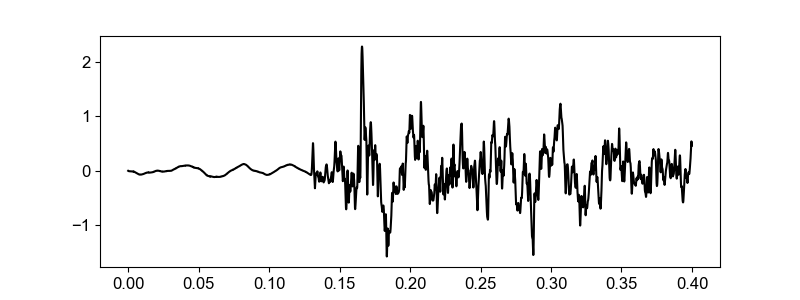

In [12]:
fig, ax = plt.subplots(figsize=(8,3))
tvec = st1[8].times()*1e3
ax.plot(tvec, st1[7].data, "k-")


# ax.set_xlim([1, 1.1])